In [1]:
import sys, os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from units import *
from tqdm import *
import pymc3 as pm
from lensing_sim import LensingSim
import corner
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.mcmc import MCMC, NUTS
import logging
import pandas as pd

logging.basicConfig(format='%(message)s', level=logging.INFO)
pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Grid size
nx, ny = 36, 36

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.


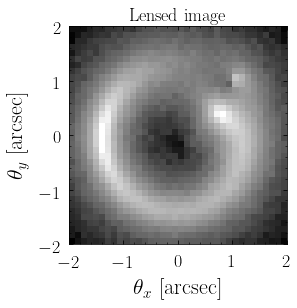

In [3]:
# Host and substructure parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.1, 'theta_y':-0.15, 'theta_E':1.14}
sub_param_dict = {'profile':'sis', 'theta_x':1., 'theta_y':1, 'theta_E':0.3}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e40*1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

# Observational parameters
observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':1e-40*(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
global_dict = {'z_s':1.0, 'z_l':0.2}

# Generate lensed image
LSI = LensingSim([hst_param_dict,sub_param_dict], [src_param_dict], global_dict, observation_dict)

i_tot = np.random.poisson((LSI.lensed_image()).numpy())

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims, origin="lower")
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');

i_tot = torch.from_numpy(i_tot)

In [32]:
i_tot = i_tot.type(torch.FloatTensor)

In [158]:
import corner

In [42]:
# def model():
#     theta_E = pyro.sample('theta_E', dist.Uniform(0.5*torch.ones(1), 1.5*torch.ones(1)))
#     theta_x = pyro.sample('theta_x', dist.Uniform(-0.2*torch.ones(1), 0.2*torch.ones(1)))
#     theta_y = pyro.sample('theta_y', dist.Uniform(-0.2*torch.ones(1), 0.2*torch.ones(1)))
    
#     theta_E_sub = pyro.sample('theta_E_sub', dist.Uniform(0.1*torch.ones(1), 0.5*torch.ones(1)))
#     theta_x_sub = pyro.sample('theta_x_sub', dist.Uniform(0.8*torch.ones(1), 1.5*torch.ones(1)))
#     theta_y_sub = pyro.sample('theta_y_sub', dist.Uniform(0.8*torch.ones(1), 1.5*torch.ones(1)))

#     hst_param_dict = {'profile':'sis', 'theta_x':theta_x.type(torch.double), 'theta_y':theta_y.type(torch.double), 'theta_E':theta_E.type(torch.double)}
#     sub_param_dict = {'profile':'sis', 'theta_x':theta_x_sub.type(torch.double), 'theta_y':theta_y_sub.type(torch.double), 'theta_E':theta_E_sub.type(torch.double)}

#     LSI.lenses_list = [hst_param_dict, sub_param_dict]

#     mu = LSI.lensed_image()
#     obs = (pyro.sample("obs", dist.Poisson(rate = mu )) )
#     return obs

# def conditioned_model(model, data):
#     return poutine.condition(model, data={"obs": data})()


# def main(jit=False, num_samples=1000, num_chains=4, warmup_steps=1000, step_size=0.1):
#     nuts_kernel = NUTS(conditioned_model, jit_compile=jit,step_size=step_size, adapt_step_size=True)
#     posterior = MCMC(nuts_kernel,
#                      num_samples=num_samples,
#                      warmup_steps=warmup_steps,
#                      num_chains=num_chains
#                     ).run(model, i_tot)
#     marginal = posterior.marginal(sites=["theta_E","theta_x","theta_y","theta_E_sub","theta_x_sub","theta_y_sub"])
#     marginal = torch.cat(list(marginal.support(flatten=True).values()), dim=-1).cpu().numpy()
#     params = ['theta_E',"theta_x","theta_y","theta_E_sub","theta_x_sub","theta_y_sub"]
#     df = pd.DataFrame(marginal, columns=params).transpose()
#     df_summary = df.apply(pd.Series.describe, axis=1)[["mean", "std", "25%", "50%", "75%"]]
#     logging.info(df_summary)
#     corner.corner(marginal)

In [44]:
# main();

In [48]:
import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
import pyro.distributions as dist
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [49]:
def model():
    theta_E = pyro.sample('theta_E', dist.Uniform(1.*torch.ones(1), 2.0*torch.ones(1)))
    theta_x = pyro.sample('theta_x', dist.Uniform(-0.2*torch.ones(1), 0.2*torch.ones(1)))
    theta_y = pyro.sample('theta_y', dist.Uniform(-0.2*torch.ones(1), 0.2*torch.ones(1)))

    theta_E_sub = pyro.sample('theta_E_sub', dist.Uniform(0.01*torch.ones(1), 0.5*torch.ones(1)))
    theta_x_sub = pyro.sample('theta_x_sub', dist.Uniform(0.05*torch.ones(1), 2*torch.ones(1)))
    theta_y_sub = pyro.sample('theta_y_sub', dist.Uniform(0.05*torch.ones(1), 2*torch.ones(1)))

    hst_param_dict = {'profile':'sis', 'theta_x':theta_x.type(torch.double), 'theta_y':theta_y.type(torch.double), 'theta_E':theta_E.type(torch.double)}
    sub_param_dict = {'profile':'sis', 'theta_x':theta_x_sub.type(torch.double), 'theta_y':theta_y_sub.type(torch.double), 'theta_E':theta_E_sub.type(torch.double)}

    LSI.lenses_list = [hst_param_dict, sub_param_dict]

    mu = LSI.lensed_image()
    with pyro.iarange("data_dim1", len(mu)):
        with pyro.iarange("data_dim2", len(mu[0])):
            obs = pyro.sample("obs", dist.Poisson(rate = mu), obs=i_tot)

In [50]:
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
guide = AutoDiagonalNormal(model)
# guide = AutoMultivariateNormal(model)

In [51]:
num_iterations = 10000
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [52]:
def train():
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step()
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / np.sum(np.shape(i_tot))))
train()

[iteration 0001] loss: 6262.1244
[iteration 0501] loss: 129.6938
[iteration 1001] loss: 119.7044
[iteration 1501] loss: 77.8006
[iteration 2001] loss: 74.3128
[iteration 2501] loss: 69.6528
[iteration 3001] loss: 73.3123
[iteration 3501] loss: 69.7125
[iteration 4001] loss: 70.1028
[iteration 4501] loss: 69.8281
[iteration 5001] loss: 69.1030
[iteration 5501] loss: 69.7271
[iteration 6001] loss: 69.3906
[iteration 6501] loss: 69.6630
[iteration 7001] loss: 70.6051
[iteration 7501] loss: 70.1741
[iteration 8001] loss: 69.6082
[iteration 8501] loss: 69.1562
[iteration 9001] loss: 69.3908
[iteration 9501] loss: 69.3974


In [53]:
svi_diagnorm_posterior = svi.run()

In [54]:
def summary(traces, sites):
    marginal = EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        marginal_site = pd.DataFrame(marginal[:, i]).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats


In [77]:
sites = ["theta_E","theta_x","theta_y","theta_E_sub","theta_x_sub","theta_y_sub"]
labels_tex = ["$\\theta_E$","$\\theta_x$","$\\theta_y$","$\\theta_E^{sub}$","$\\theta_x^{sub}$","$\\theta_y^{sub}$"]

for site, values in summary(svi_diagnorm_posterior, sites).items():
    print("Site: {}".format(site))
    print(values, "\n")


Site: theta_E
      mean       std        5%       25%       50%       75%       95%
0  1.13853  0.000202  1.138214  1.138394  1.138529  1.138654  1.138869 

Site: theta_x
       mean       std        5%       25%       50%       75%       95%
0  0.100438  0.000423  0.099758  0.100145  0.100431  0.100722  0.101134 

Site: theta_y
       mean      std        5%       25%       50%       75%      95%
0 -0.150278  0.00028 -0.150708 -0.150473 -0.150284 -0.150088 -0.14982 

Site: theta_E_sub
       mean       std        5%       25%       50%       75%       95%
0  0.299247  0.000177  0.298944  0.299133  0.299254  0.299359  0.299548 

Site: theta_x_sub
      mean       std        5%       25%       50%       75%       95%
0  1.00295  0.001232  1.000933  1.002099  1.002959  1.003754  1.004952 

Site: theta_y_sub
       mean       std        5%       25%       50%       75%      95%
0  1.002285  0.001294  1.000086  1.001427  1.002288  1.003186  1.00435 



/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.


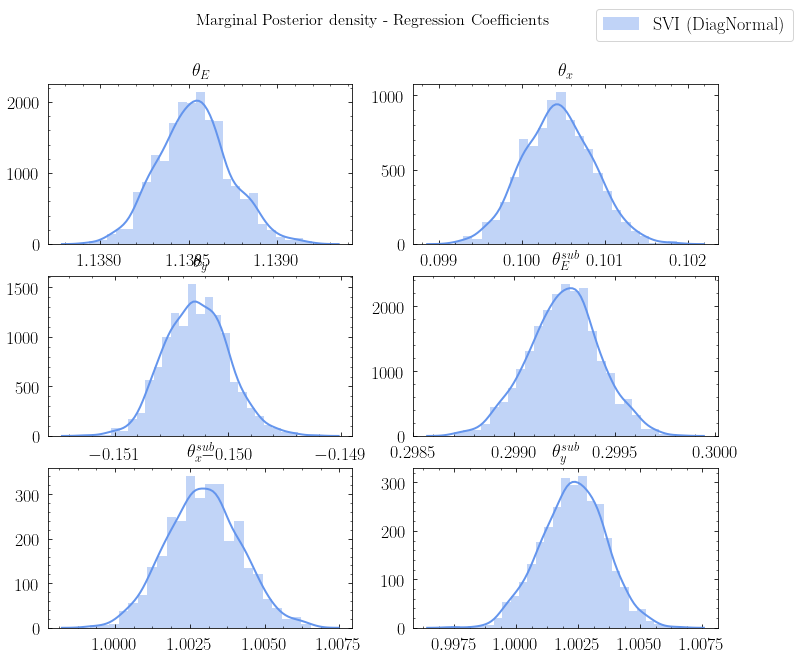

In [79]:
svi_diagnorm_empirical = EmpiricalMarginal(svi_diagnorm_posterior, sites=sites) \
                         ._get_samples_and_weights()[0] \
                         .detach().cpu().numpy()
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    sns.distplot(svi_diagnorm_empirical[:, i], ax=ax, label="SVI (DiagNormal)")
    
    ax.set_title(labels_tex[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')


## ConvNet

In [356]:
# Grid size
nx, ny = 28, 28

In [357]:
# # Host and substructure parameters
# hst_param_dict = {'profile':'sis', 'theta_x':0.1, 'theta_y':-0.15, 'theta_E':1.14}


# Ntrain = 50000
# N = np.random.randint(0, 20, Ntrain)#.astype(np.float32)

# coords = np.random.uniform(low=-2, high=2, size=(Ntrain,2))

# i_list = []

# for iNidx, iN in enumerate(tqdm_notebook(N)):
    
#     lens_list = [hst_param_dict]
#     for _ in range((iN)):
#         sub_param_dict = {'profile':'sis', 'theta_x':coords[iNidx][0], 'theta_y':coords[iNidx][1], 'theta_E':0.01}
#         lens_list.append(sub_param_dict)

#     # Observational parameters
#     observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':1e-40*(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
#     global_dict = {'z_s':1.0, 'z_l':0.2}

#     # Generate lensed image
#     LSI = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)

#     i_tot = ((LSI.lensed_image()).numpy())
# #     i_tot = np.random.poisson((LSI.lensed_image()).numpy())

#     i_list.append(np.array([i_tot]).transpose((1,2,0)))


In [364]:
# Host and substructure parameters


Ntrain = 10000
N = np.random.uniform(0.0, 2, Ntrain)#.astype(np.float32)
coords = np.random.uniform(low=-2, high=2, size=(Ntrain,2))

i_list = []

for iNidx, iN in enumerate(tqdm_notebook(N)):
    
    
#     for _ in range((iN)):
    hst_param_dict = {'profile':'sis', 'theta_x':coords[iNidx][0], 'theta_y':coords[iNidx][1], 'theta_E':iN}
    lens_list = [hst_param_dict]
#     sub_param_dict = {'profile':'sis', 'theta_x':1, 'theta_y':0, 'theta_E':iN}
#     lens_list.append(sub_param_dict)

    # Observational parameters
    observation_dict = {'nx':nx, 'ny':ny, 'xlims':[-2, 2], 'ylims':[-2, 2], 'exposure':1e-40*(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2, 'z_s':1.0, 'z_l':0.2}
    global_dict = {'z_s':1.0, 'z_l':0.2}

    # Generate lensed image
    LSI = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)

    i_tot = ((LSI.lensed_image()).numpy())
#     i_tot = np.random.poisson((LSI.lensed_image()).numpy())

    i_list.append(np.array([i_tot]).transpose((1,2,0)))


In [493]:
N_samp_train = 100000
N_samp_test = 100000

In [494]:
N_samp = N_samp_train + N_samp_test

Y_E = np.ones(N_samp)*1 #np.random.uniform(0.5, 1.5, N_samp)
Y_x = np.ones(N_samp)*0.01 #np.random.uniform(-0.04, 0.04, N_samp)
Y_y = np.ones(N_samp)*0.01 #np.random.uniform(-0.04, 0.04, N_samp)

# Pick substructure position to always lie at Einstein radius for now
Y_sub_x = np.random.uniform(-Y_E, Y_E, N_samp)
Y_sub_y = np.sqrt(Y_E**2 - Y_sub_x**2)
Y_sub_logM = np.random.uniform(0, 0.3, N_samp)

N = Y_sub_logM

LSI = LensingSim(sources_list=[src_param_dict], global_dict=global_dict, observation_dict=observation_dict)

i_list = []

for isamp in tqdm(range(N_samp)):
    hst_param_dict = {'profile':'sis','theta_x':Y_x[isamp], 'theta_y':Y_y[isamp], 'theta_E':Y_E[isamp]}
    sub_param_dict = {'profile':'sis','theta_x':Y_sub_x[isamp], 'theta_y':Y_sub_y[isamp], 'theta_E':Y_sub_logM[isamp]}
    
    LSI.lenses_list = [hst_param_dict, sub_param_dict]
    i_list.append(np.array([LSI.lensed_image().numpy()]).transpose((1,2,0)))
    
    
    

100%|██████████| 200000/200000 [01:56<00:00, 1718.22it/s]


In [495]:
N = N.astype(np.float32)

In [496]:
i_list = (np.array(i_list))

0.29752895


No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.


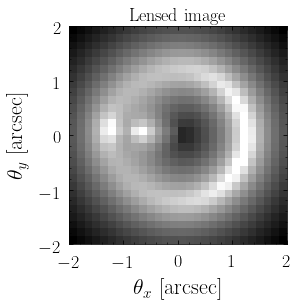

In [497]:
idx = np.random.randint(0, Ntrain, 1)[0]

print(N[idx])

plt.imshow(np.log10(i_list[idx][:,:,0]), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims, origin="lower")
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');

In [498]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [499]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [500]:
class LensingDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, images, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = images
        self.labels = labels
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].transpose((2, 0, 1))).type(torch.FloatTensor)
        label = (self.labels[idx])
        
        return image, label

In [501]:
# Hyper parameters
num_epochs = 20
num_classes = 1
batch_size = 200
learning_rate = 0.001

In [502]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [503]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Sequential(nn.Linear(128, 512))
        self.fc3 = nn.Sequential(nn.Linear(512, 1024))
        self.fc4 = nn.Sequential(nn.Linear(1024, 1))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

model = ConvNet().to(device)

In [507]:
train_dataset = LensingDataset(np.array(i_list)[:50000], N[:50000])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [508]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [509]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/20], Step [10/250], Loss: 0.0157
Epoch [1/20], Step [20/250], Loss: 0.0640
Epoch [1/20], Step [30/250], Loss: 0.0132
Epoch [1/20], Step [40/250], Loss: 0.0079
Epoch [1/20], Step [50/250], Loss: 0.0079
Epoch [1/20], Step [60/250], Loss: 0.0088
Epoch [1/20], Step [70/250], Loss: 0.0080
Epoch [1/20], Step [80/250], Loss: 0.0074
Epoch [1/20], Step [90/250], Loss: 0.0079
Epoch [1/20], Step [100/250], Loss: 0.0079
Epoch [1/20], Step [110/250], Loss: 0.0076
Epoch [1/20], Step [120/250], Loss: 0.0080
Epoch [1/20], Step [130/250], Loss: 0.0079
Epoch [1/20], Step [140/250], Loss: 0.0075
Epoch [1/20], Step [150/250], Loss: 0.0082
Epoch [1/20], Step [160/250], Loss: 0.0077
Epoch [1/20], Step [170/250], Loss: 0.0077
Epoch [1/20], Step [180/250], Loss: 0.0075
Epoch [1/20], Step [190/250], Loss: 0.0082
Epoch [1/20], Step [200/250], Loss: 0.0073
Epoch [1/20], Step [210/250], Loss: 0.0078
Epoch [1/20], Step [220/250], Loss: 0.0072
Epoch [1/20], Step [230/250], Loss: 0.0066
Epoch [1/20], Step [

In [510]:
test_dataset = LensingDataset(np.array(i_list)[:50000], N[:50000])

# Data loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=1, 
                                           shuffle=False)

In [511]:
pred = []
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
#         print([(labels.numpy()[0]), (outputs.numpy()[0][0])])
        pred.append([(labels.numpy()[0]), (outputs.numpy()[0][0])])



No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.
No LaTeX-compatible font found for the serif font family in rcParams. Using default.


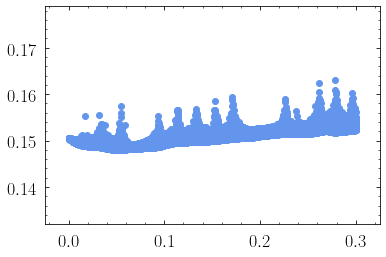

In [512]:
plt.scatter(np.array(pred)[:,0], np.array(pred)[:,1])
# plt.xlim(0,2)
# plt.ylim(0,2)